<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 4 Lesson 1*

# Recurrent Neural Networks and Long Short Term Memory (LSTM)
## _aka_ PREDICTING THE FUTURE!

<img src="https://media.giphy.com/media/l2JJu8U8SoHhQEnoQ/giphy.gif" width=480 height=356>
<br></br>
<br></br>

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

## Time series with plain old regression

Recurrences are fancy, and we'll get to those later - let's start with something simple. Regression can handle time series just fine if you just set them up correctly - let's try some made-up stock data. And to make it, let's use a few list comprehensions!

In [2]:
import numpy as np
from random import random
days = np.array((range(28)))
stock_quotes = np.array([random() + day * random() for day in days]) #autocorrelating time and stock

In [3]:
stock_quotes

array([ 0.53770288,  0.86336839,  0.73517059,  3.1922686 ,  4.17708386,
        0.25692901,  2.58155067,  2.75102524,  0.72352409,  8.03285774,
        1.15896662,  5.35135391,  9.00617763, 10.07242455, 13.55582162,
        1.07495833, 12.00260954, 16.42329937,  6.61118778,  1.34368721,
       20.1701102 , 19.95614621, 14.018627  , 21.77836078,  7.09015898,
        8.52873082, 17.86113645, 24.38526919])

Let's take a look with a scatter plot:

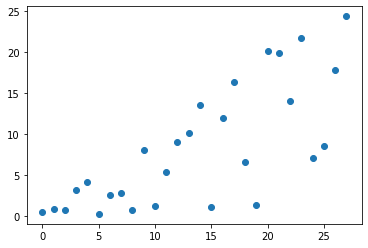

In [5]:
from matplotlib.pyplot import scatter
scatter(days, stock_quotes)

Looks pretty linear, let's try a simple OLS regression.

First, these need to be NumPy arrays:

In [6]:
days = days.reshape(-1, 1)  # X needs to be column vectors

In [7]:
days

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27]])

Now let's use good old `scikit-learn` and linear regression:

In [9]:
from sklearn.linear_model import LinearRegression
ols_stocks = LinearRegression()
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.5629179757086855

That seems to work pretty well, but real stocks don't work like this.

Let's make *slightly* more realistic data that depends on more than just time:

In [10]:
# Not everything is best as a comprehension
stock_data = np.empty([len(days), 4])
for day in days:
  asset = random()
  liability = random()
  quote = random() + ((day * random()) + (20 * asset) - (15 * liability))
  quote = max(quote, 0.01)  # Want positive quotes
  stock_data[day] = np.array([quote, day, asset, liability])

In [11]:
stock_data

array([[2.67439053e+00, 0.00000000e+00, 5.34875620e-01, 5.86616876e-01],
       [1.25681520e+01, 1.00000000e+00, 6.78720146e-01, 1.41501098e-01],
       [1.16998056e+01, 2.00000000e+00, 5.95429304e-01, 3.29680218e-02],
       [9.95074324e+00, 3.00000000e+00, 5.62328518e-01, 1.97504565e-01],
       [9.40010447e-02, 4.00000000e+00, 3.07725275e-01, 6.91854742e-01],
       [7.99280665e+00, 5.00000000e+00, 4.50402992e-01, 3.65218833e-01],
       [1.00000000e-02, 6.00000000e+00, 1.59304651e-01, 5.96986498e-01],
       [1.22719078e+01, 7.00000000e+00, 8.24836632e-01, 4.11131643e-01],
       [1.04421213e+01, 8.00000000e+00, 9.38226678e-01, 9.80541136e-01],
       [2.08508154e+00, 9.00000000e+00, 1.91901871e-01, 4.26912208e-01],
       [1.00000000e-02, 1.00000000e+01, 5.45471422e-02, 7.53401316e-01],
       [4.54133234e+00, 1.10000000e+01, 1.70183958e-01, 2.70223220e-01],
       [2.12519504e+01, 1.20000000e+01, 5.84000513e-01, 1.57443012e-01],
       [1.06073773e+01, 1.30000000e+01, 9.58667424e

Let's look again:

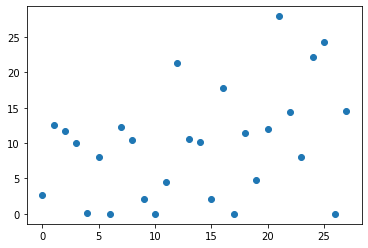

In [12]:
stock_quotes = stock_data[:,0]
scatter(days, stock_quotes);

How does our old model do?

In [13]:
days = np.array(days).reshape(-1, 1)
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.1304018805642806

Not bad, but can we do better?

In [14]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.score(stock_data[:,1:], stock_quotes)

0.7096344785385665

Yep - unsurprisingly, the other covariates (assets and liabilities) have info.

But, they do worse without the day data.

In [15]:
ols_stocks.fit(stock_data[:,2:], stock_quotes)
ols_stocks.score(stock_data[:,2:], stock_quotes)

0.4548418085645855

## Time series jargon

There's a lot of semi-standard language and tricks to talk about this sort of data. [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm) has an excellent guidebook, but here are some highlights:

### Moving average

Moving average aka rolling average aka running average.

Convert a series of data to a series of averages of continguous subsets:

In [16]:
stock_quotes_rolling = [sum(stock_quotes[i:i+3]) / 3
                        for i in range(len(stock_quotes - 2))]
stock_quotes_rolling

[8.980782701207195,
 11.406233604516785,
 7.248183290341171,
 6.01251697941414,
 2.6989358986455128,
 6.758238157784441,
 7.5746763818165475,
 8.266370227403556,
 4.179067620026775,
 2.2121379578806906,
 8.601094256599755,
 12.133553367575013,
 14.000511302407952,
 7.625414859260315,
 10.022262053035277,
 6.644860005908659,
 9.73012860228899,
 5.4040525408031,
 9.412027546373134,
 14.918049182602369,
 18.09541171402879,
 16.784427813078228,
 14.860057784575266,
 18.171585234865393,
 15.47459413024592,
 12.945898974690214,
 4.850445416376003,
 4.84711208304267]

Pandas has nice series related functions:

In [17]:
import pandas as pd
df = pd.DataFrame(stock_quotes)
df.rolling(3).mean()

,0
0,NaN
1,NaN
2,8.980783
3,11.406234
4,7.248183
5,6.012517
6,2.698936
7,6.758238
8,7.574676
9,8.266370


### Forecasting

Forecasting - at it's simplest, it just means "predict the future":

In [18]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.predict([[29, 0.5, 0.5]])

array([18.48753373])

One way to predict if you just have the series data is to use the prior observation. This can be pretty good (if you had to pick one feature to model the temperature for tomorrow, the temperature today is a good choice).

In [19]:
temperature = np.array([30 + random() * day
                        for day in np.array(range(365)).reshape(-1, 1)])
temperature_next = temperature[1:].reshape(-1, 1)
temperature_ols = LinearRegression()
temperature_ols.fit(temperature[:-1], temperature_next)
temperature_ols.score(temperature[:-1], temperature_next)

0.14666134425697552

But you can often make it better by considering more than one prior observation.

In [20]:
temperature_next_next = temperature[2:].reshape(-1, 1)
temperature_two_past = np.concatenate([temperature[:-2], temperature_next[:-1]],
                                      axis=1)
temperature_ols.fit(temperature_two_past, temperature_next_next)
temperature_ols.score(temperature_two_past, temperature_next_next)

0.18901811290702464

### Exponential smoothing

Exponential smoothing means using exponentially decreasing past weights to predict the future.

You could roll your own, but let's use Pandas.

In [21]:
temperature_df = pd.DataFrame(temperature)
temperature_df.ewm(halflife=7).mean()

,0
0,30.000000
1,30.245588
2,30.328555
3,30.862733
4,31.080080
5,31.452611
6,32.036551
7,31.806408
8,31.590915
9,32.626476


Halflife is among the parameters we can play with:

In [22]:
sse_1 = ((temperature_df - temperature_df.ewm(halflife=7).mean())**2).sum()
sse_2 = ((temperature_df - temperature_df.ewm(halflife=3).mean())**2).sum()
print(sse_1)
print(sse_2)

0    1.193309e+06
dtype: float64
0    969642.464121
dtype: float64


Note - the first error being higher doesn't mean it's necessarily *worse*. It's *smoother* as expected, and if that's what we care about - great!

### Seasonality

Seasonality - "day of week"-effects, and more. In a lot of real world data, certain time periods are systemically different, e.g. holidays for retailers, weekends for restaurants, seasons for weather.

Let's try to make some seasonal data - a store that sells more later in a week:

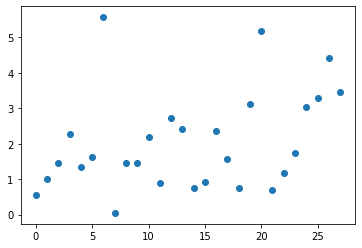

In [23]:
sales = np.array([random() + (day % 7) * random() for day in days])
scatter(days, sales)

How does linear regression do at fitting this?

In [24]:
sales_ols = LinearRegression()
sales_ols.fit(days, sales)
sales_ols.score(days, sales)

0.13023322892994238

That's not great - and the fix depends on the domain. Here, we know it'd be best to actually use "day of week" as a feature.

In [25]:
day_of_week = days % 7
sales_ols.fit(day_of_week, sales)
sales_ols.score(day_of_week, sales)

0.5684640774601243

Note that it's also important to have representative data across whatever seasonal feature(s) you use - don't predict retailers based only on Christmas, as that won't generalize well.

## Recurrent Neural Networks

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/
- https://seekingalpha.com/article/4087604-much-artificial-intelligence-ibm-watson

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

### RNN/LSTM Sentiment Classification with Keras

In [26]:
# larger batch sizes allow RNNs to converge faster and weigh more into batches

In [27]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
# taking the first 80 chars will make the results converge faster, though the model can take variable size inputs
batch_size = 32
# relatively small batch size for RNN

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
# This is a pre-processing technique that chops X into 80 char chunks and turn them into time sequences


print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)


W0722 15:44:29.031691 140559078836032 deprecation.py:506] From /home/nedderlander/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0722 15:44:29.043685 140559078836032 deprecation.py:506] From /home/nedderlander/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...


W0722 15:44:29.298710 140559078836032 deprecation.py:323] From /home/nedderlander/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 71s 3ms/sample - loss: 0.4577 - acc: 0.7846 - val_loss: 0.3868 - val_acc: 0.8318
Epoch 2/15
25000/25000 [==============================] - 73s 3ms/sample - loss: 0.2912 - acc: 0.8819 - val_loss: 0.3786 - val_acc: 0.8388
Epoch 3/15
25000/25000 [==============================] - 71s 3ms/sample - loss: 0.2116 - acc: 0.9184 - val_loss: 0.4049 - val_acc: 0.8362
Epoch 4/15
25000/25000 [==============================] - 71s 3ms/sample - loss: 0.1508 - acc: 0.9448 - val_loss: 0.5127 - val_acc: 0.8296
Epoch 5/15
25000/25000 [==============================] - 70s 3ms/sample - loss: 0.1051 - acc: 0.9624 - val_loss: 0.4897 - val_acc: 0.8270
Epoch 6/15
25000/25000 [==============================] - 70s 3ms/sample - loss: 0.0774 - acc: 0.9733 - val_loss: 0.6588 - val_acc: 0.8230
Epoch 7/15
25000/25000 [==============================] - 70s 3ms/sample - loss: 0.0555 - acc: 0.9818 - val

### RNN Text generation with NumPy

What else can we do with RNN? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. We'll pull some news stories using [newspaper](https://github.com/codelucas/newspaper/).

#### Initialization

In [30]:
!pip install newspaper3k

     |████████████████████████████████| 215kB 1.7MB/s 
     |████████████████████████████████| 194kB 3.2MB/s 
     |████████████████████████████████| 51kB 3.6MB/s 
     |████████████████████████████████| 7.4MB 7.4MB/s 
  Stored in directory: /home/nedderlander/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
  Stored in directory: /home/nedderlander/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Stored in directory: /home/nedderlander/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Stored in directory: /home/nedderlander/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
Successfully built feedparser tinysegmenter jieba3k feedfinder2


In [31]:
import newspaper

ModuleNotFoundError: No module named 'newspaper'

In [30]:
ap = newspaper.build('http://ap.com')
len(ap.articles)

NameError: name 'newspaper' is not defined

In [29]:
article_text = ''

for article in ap.articles[:1]:
    try:
        article.download()
        article.parse()
        article_text += '\n\n' + article.text
    except:
        print('Failed: ' + article.url)

article_text = article_text.split('\n\n')[1]
print(article_text)

NameError: name 'ap' is not defined

In [46]:
# Based on "The Unreasonable Effectiveness of RNN" implementation
import numpy as np

chars = list(set(article_text)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(article_text)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)

unique characters :  55
txt_data_size :  486


In [47]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in article_text] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'r': 0, '-': 1, 'I': 2, '1': 3, 'G': 4, 'v': 5, 'c': 6, 'a': 7, 'd': 8, 'u': 9, 'y': 10, 'm': 11, 'P': 12, ':': 13, 'H': 14, 'U': 15, '’': 16, '4': 17, 'R': 18, ' ': 19, 'n': 20, 'E': 21, 'f': 22, '…': 23, '(': 24, 'h': 25, '8': 26, 'l': 27, ')': 28, 'q': 29, 'L': 30, 'T': 31, '9': 32, '7': 33, 'S': 34, 'j': 35, 't': 36, 'w': 37, 'Q': 38, 'N': 39, ',': 40, '—': 41, 'b': 42, 's': 43, '.': 44, 'e': 45, 'V': 46, 'O': 47, 'i': 48, '“': 49, 'g': 50, 'p': 51, 'k': 52, 'o': 53, 'A': 54}
----------------------------------------------------
{0: 'r', 1: '-', 2: 'I', 3: '1', 4: 'G', 5: 'v', 6: 'c', 7: 'a', 8: 'd', 9: 'u', 10: 'y', 11: 'm', 12: 'P', 13: ':', 14: 'H', 15: 'U', 16: '’', 17: '4', 18: 'R', 19: ' ', 20: 'n', 21: 'E', 22: 'f', 23: '…', 24: '(', 25: 'h', 26: '8', 27: 'l', 28: ')', 29: 'q', 30: 'L', 31: 'T', 32: '9', 33: '7', 34: 'S', 35: 'j', 36: 't', 37: 'w', 38: 'Q', 39: 'N', 40: ',', 41: '—', 42: 'b', 43: 's', 44: '.', 45: 'e', 46: 'V', 47: 'O', 48: 'i', 49: '“', 50: 'g', 51: 'p', 52

In [54]:
# hyperparameters

iteration = 1000
sequence_length = 40
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
hidden_size = 500  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

#### Forward propagation

In [55]:
def forwardprop(inputs, targets, h_prev):
    """
    The forward prop pass in our example creates a log proba for each character in a sequence.
    
    "ABCD EFG"
    Take this sequences and with our current weights it'll look at "A" and try to predict the next character.
    We had 49 characters in our vovab so our softmax will predict which of the 49 we will get next
    
    """
    
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars. 
        
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code
        
        
        print([int_to_char[char] for char in ps[t]])
        print ([int_to_char[char] for char in targets[t]])
        
#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)        

    return loss, ps, hs, xs

#### Backward propagation

In [56]:
def backprop(ps, inputs, hs, xs, targets):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

#### Training

In [58]:
# %%time

data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 

for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch] for ch in article_text[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch] for ch in article_text[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(article_text) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs, targets) 
        
        
        # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress

iter 0, loss: 235.968912
iter 100, loss: 3.286046
iter 200, loss: 2.774669
iter 300, loss: 2.382193
iter 400, loss: 3.248081
iter 500, loss: 2.315543
iter 600, loss: 2.177977
iter 700, loss: 2.022759
iter 800, loss: 2.026381
iter 900, loss: 4.045268


#### Prediction

In [59]:
def predict(test_char, length):
    x = np.zeros((num_chars, 1)) 
    x[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, x) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = test_char + ''.join(int_to_char[i] for i in ixes)
    print ('----\n %s \n----' % (txt, ))

In [ ]:
predict('T', 50)

----
 Therm019,hursip tha k . (Photo:a(Pug a  aXt sid Rob 
----


Well... that's *vaguely* language-looking. Can you do better?

# Assignment

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [1]:
# TODO - Words, words, mere words, no matter from the heart.

# complete works of shakespeare
filename = '100-0.txt'
raw_text = open(filename).read().lower()

In [2]:
# create a mapping of unique chars to ints
chars = sorted(list(set(raw_text)))
char_to_int = dict((c,i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [3]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  5564374
Total Vocab:  73


In [4]:
# encode txt as ints

seq_length = 100

X = []
y = []

for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    X.append([char_to_int[char] for char in seq_in])
    y.append(char_to_int[seq_out])
n_patterns = len(X)
print("Total patterns: {}".format(n_patterns))

Total patterns: 5564274


In [ ]:
# reshape X to be [samples, time steps, features]
from numba import jit
import numpy as np

# reshape and normalize
# @jit(nopython=True)
def reshape(array, dim1, dim2, dim3, norm):
    return (np.reshape(array, (dim1, dim2, dim3)) / float(norm))

X = reshape(X, n_patterns, seq_length, 1, n_vocab)

# X = X / float(n_vocab)


In [ ]:
# ohe output variable
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, n_vocab)

In [5]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split

# define our LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# define checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = "weights-improvement-{epoch:02d} -{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

AttributeError: 'list' object has no attribute 'shape'

In [11]:
# fit this bad boy
model.fit(X, y, epochs=20, batch_size = 32, callbacks=callbacks_list)

W0723 00:24:03.748682 140314906519360 deprecation.py:323] From /home/nedderlander/anaconda3/envs/tensorflow_gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
5564256/5564274 [============================>.] - ETA: 0s - loss: 2.3678 - acc: 0.3201
Epoch 00001: loss improved from inf to 2.36775, saving model to weights-improvement-01 -2.3678.hdf5
5564274/5564274 [==============================] - 14179s 3ms/sample - loss: 2.3678 - acc: 0.3201
Epoch 2/20
5564256/5564274 [============================>.] - ETA: 0s - loss: 2.0895 - acc: 0.3942
Epoch 00002: loss improved from 2.36775 to 2.08954, saving model to weights-improvement-02 -2.0895.hdf5
5564274/5564274 [==============================] - 14422s 3ms/sample - loss: 2.0895 - acc: 0.3942
Epoch 3/20
 132896/5564274 [..............................] - ETA: 4:28:35 - loss: 2.0142 - acc: 0.4163

KeyboardInterrupt: 

In [ ]:
# load the network weights
filename = 'weights-improvement-02 -2.0895.hdf5'
model.load_weights(filename)

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
# first use our 

In [45]:
# use sonnets for prediction
# read in text of sonnets
path = './sonnets.txt'
poems = [line.split('\n') for line in open(path).read().split('\n\n')]
sonnets = [line for line in poems if len(line) > 2]

# create sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence

tokens_list = [text_to_word_sequence(str(text).replace("'", '')) for text in sonnets]

# create a random seed
start = np.random.randint(0, len(tokens_list)-1)

# use it to find a poem
pattern = tokens_list[start]

# break poem into chars
from functools import reduce 
words = [word for word in poem]
poem_chars = reduce(lambda x,y: str(x+y), poem)[:100] 

print('Seed: ', poem_chars)
poem_ints = [char_to_int[str(value)] for value in poem_chars]
print((poem_ints))



# predict some characters

for i in range(1000):
    x = np.reshape(poem_ints, (1, len(poem_ints), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    sequ_in = [int_to_char[value] for value in poem_ints]
    sys.stdout.write(result)
    poem_chars.append(index)
    poem_chars = poem_chars[1:len(poem_chars)]

Seed:  mineeyehathplayedthepainterandhathstelledthybeauty’sformintableofmyheartmybodyistheframewherein’tish
[43, 39, 44, 35, 35, 55, 35, 38, 31, 50, 38, 46, 42, 31, 55, 35, 34, 50, 38, 35, 46, 31, 39, 44, 50, 35, 48, 31, 44, 34, 38, 31, 50, 38, 49, 50, 35, 42, 42, 35, 34, 50, 38, 55, 32, 35, 31, 51, 50, 55, 70, 49, 36, 45, 48, 43, 39, 44, 50, 31, 32, 42, 35, 45, 36, 43, 55, 38, 35, 31, 48, 50, 43, 55, 32, 45, 34, 55, 39, 49, 50, 38, 35, 36, 48, 31, 43, 35, 53, 38, 35, 48, 35, 39, 44, 70, 50, 39, 49, 38]


KeyError: 'm'

# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN

In [2]:
# below I tried to predict the words in sonnets, rather than letters and did not fully succeed.

import pandas as pd
import numpy as np
import os
import re

In [3]:
# do homework with keras first

# read in text of sonnets
path = './sonnets.txt'
poems = [line.split('\n') for line in open(path).read().split('\n\n')]
sonnets = [line for line in poems if len(line) > 2]

In [4]:
# create sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence

tokens_list = [text_to_word_sequence(str(text).replace("'", '')) for text in sonnets]

vocab = set()
for text in tokens_list:
    for word in text:
        vocab.add(word)
        
len(tokens_list)

154

In [5]:
# now I have a vocab and a list of lists (tokens_list) where each inner list is a sonnet
# I'm sort of lost so I'm actually going to just use the keras tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer

t = Tokenizer()

t.fit_on_texts(tokens_list)


In [6]:
# summarize what was learned
# print(t.word_counts) #a dictionary of words and their counts
# print(t.document_count) #a dictionary of words and documents they appeared int
# print(t.word_index) #a dictinary of words and their integers
# print(t.word_docs) #an interger count of the total number of documents used to fit the T

In [37]:
# I'll take the first part of each sonnet as training, and the end as test


X = []
y = []

for sonnet in tokens_list:
    X.append(sonnet[:int(len(sonnet)*.8)])
    y.append(sonnet[-(int(len(sonnet)*.2)):])
        

In [44]:
print('X 0: ', X[0])
print('y 0: ', y[0])
print('token 0: ', tokens_list[0])

# looks like we lost one word, seems ok

X 0:  ['from', 'fairest', 'creatures', 'we', 'desire', 'increase', 'that', 'thereby', 'beauty’s', 'rose', 'might', 'never', 'die', 'but', 'as', 'the', 'riper', 'should', 'by', 'time', 'decease', 'his', 'tender', 'heir', 'might', 'bear', 'his', 'memory', 'but', 'thou', 'contracted', 'to', 'thine', 'own', 'bright', 'eyes', 'feed’st', 'thy', 'light’s', 'flame', 'with', 'self', 'substantial', 'fuel', 'making', 'a', 'famine', 'where', 'abundance', 'lies', 'thy', 'self', 'thy', 'foe', 'to', 'thy', 'sweet', 'self', 'too', 'cruel', 'thou', 'that', 'art', 'now', 'the', 'world’s', 'fresh', 'ornament', 'and', 'only', 'herald', 'to', 'the', 'gaudy', 'spring', 'within', 'thine', 'own', 'bud', 'buriest', 'thy', 'content', 'and', 'tender', 'churl']
y 0:  ['waste', 'in', 'niggarding', 'pity', 'the', 'world', 'or', 'else', 'this', 'glutton', 'be', 'to', 'eat', 'the', 'world’s', 'due', 'by', 'the', 'grave', 'and', 'thee']
token 0:  ['from', 'fairest', 'creatures', 'we', 'desire', 'increase', 'that', 'th

In [45]:
# now I'll encode our documents
X = t.texts_to_matrix(X, mode='tfidf')
y = t.texts_to_matrix(y, mode='tfidf')

In [62]:
X.shape, y.shape

((154, 3194), (154, 3194))

In [68]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split

# build fast training keras model
max_features = 20000
# cut texts after this number of words (among top max_features most common words)

maxlen = 80
# taking the first 80 chars will make the results converge faster, though the model can take variable size inputs

batch_size = 32
# relatively small batch size for RNN

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
# This is a pre-processing technique that chops X into 80 char chunks and turn them into time sequences

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(256, return_sequences=True))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Pad sequences (samples x time)
Build model...
Train...
Train on 138 samples, validate on 16 samples
Epoch 1/15
138/138 [==============================] - 2s 12ms/sample - loss: 374.3072 - acc: 0.0000e+00 - val_loss: 386.0551 - val_acc: 0.0000e+00
Epoch 2/15
138/138 [==============================] - 1s 5ms/sample - loss: 352.9733 - acc: 0.0000e+00 - val_loss: 370.6561 - val_acc: 0.0000e+00
Epoch 3/15
138/138 [==============================] - 1s 5ms/sample - loss: 320.5945 - acc: 0.0000e+00 - val_loss: 390.8481 - val_acc: 0.0000e+00
Epoch 4/15
138/138 [==============================] - 1s 5ms/sample - loss: 313.0193 - acc: 0.0000e+00 - val_loss: 421.5773 - val_acc: 0.0000e+00
Epoch 5/15
138/138 [==============================] - 1s 5ms/sample - loss: 317.0777 - acc: 0.0000e+00 - val_loss: 452.2933 - val_acc: 0.0000e+00
Epoch 6/15
138/138 [==============================] - 1s 5ms/sample - loss: 324.6608 - acc: 0.0000e+00 - val_loss: 482.1810 - val_acc: 0.0000e+00
Epoch 7/15
138/138 [===

In [69]:
# now let's make a prediction!

# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, t.word_index.items()))

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

def process_for_prediction(input):
    
    matrix = t.texts_to_matrix(input, mode='tfidf')
    output = sequence.pad_sequences(matrix, maxlen=maxlen)
    
    return output


test = tokens_list[42][:80]
raw_prediction = model.predict(process_for_prediction(test))
# sequence_to_text(raw_prediction)
raw_prediction

# failed to return to text

array([[1.80110408e-12, 4.78074998e-02, 2.70368792e-02, ...,
        3.07860319e-07, 1.17861454e-07, 9.26677757e-08],
       [1.80110408e-12, 4.78074998e-02, 2.70368792e-02, ...,
        3.07860319e-07, 1.17861454e-07, 9.26677757e-08],
       [1.80110408e-12, 4.78074998e-02, 2.70368792e-02, ...,
        3.07860319e-07, 1.17861454e-07, 9.26677757e-08],
       ...,
       [1.80110408e-12, 4.78074998e-02, 2.70368792e-02, ...,
        3.07860319e-07, 1.17861454e-07, 9.26677757e-08],
       [1.80110408e-12, 4.78074998e-02, 2.70368792e-02, ...,
        3.07860319e-07, 1.17861454e-07, 9.26677757e-08],
       [1.80110408e-12, 4.78074998e-02, 2.70368792e-02, ...,
        3.07860319e-07, 1.17861454e-07, 9.26677757e-08]], dtype=float32)

In [6]:
def vectorize(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1a
        return results

In [ ]:

# then try a single RNN cell 